## LAB1 B: Harris Laplacian of Gaussian

Note: I resized `book2.jpg` to be similar in size to `book1.jpg` for consistency,

### Proceedure:

- Use `book1.jpg` and `book2.jpg`, perform Harris LoG.
- Try matching the detected corners between the 2 images based on similarity.
- Missing `t1.png`, will ignroe this.
- Rotate an image by a random angle and scale it by a random factor.
- Use Harris LoG on rotated and original image, align and compare their position.

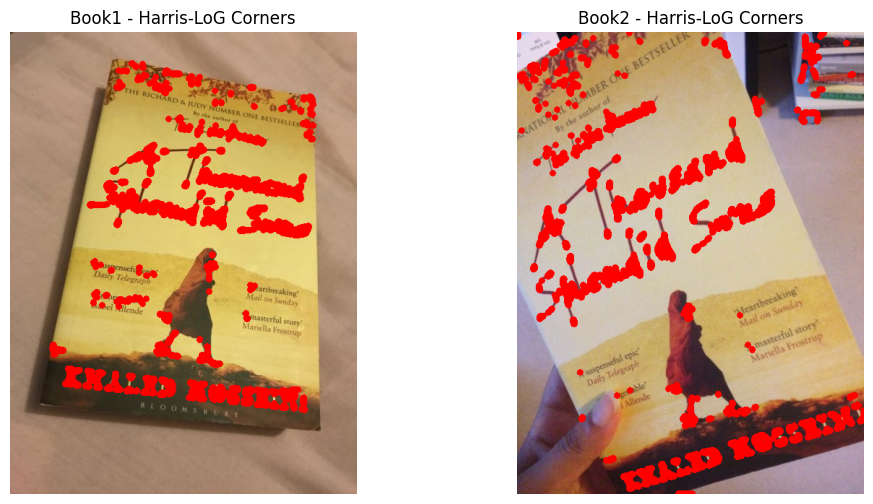

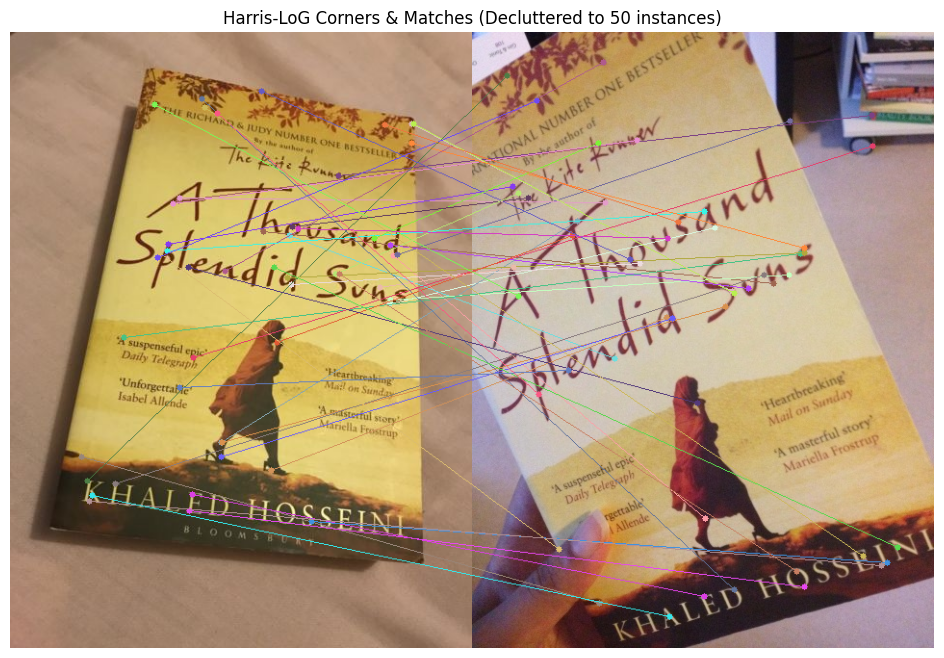

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Load images
img1 = cv2.imread('data/book1.jpg')
img2 = cv2.imread('data/book2.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Harris + LoG (scale selection)
def harris_log_corners(img, scales=[1.0, 2.0, 3.0], k=0.04, harris_thresh=0.03):
    img_corners = img.copy()
    all_corners = []

    for sigma in scales:
        # Smooth image for this scale
        gray = cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (0,0), sigma)
        gray_f = np.float32(gray)
        
        # Compute Harris response
        dst = cv2.cornerHarris(gray_f, 2, 3, k)
        dst = cv2.dilate(dst, None)
        corners = np.argwhere(dst > harris_thresh * dst.max())
        corners = [tuple(pt[::-1]) for pt in corners]
        all_corners.extend(corners)
    
    # Remove duplicates (nearby points)
    all_corners = list(set(all_corners))
    
    # Draw corners
    for c in all_corners:
        cv2.circle(img_corners, c, 3, (0,0,255), -1)
    
    return img_corners, all_corners

# Detect Harris-LoG corners
img1_c, corners1 = harris_log_corners(img1)
img2_c, corners2 = harris_log_corners(img2)

# Display images with corners side by side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Book1 - Harris-LoG Corners")
plt.imshow(cv2.cvtColor(img1_c, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Book2 - Harris-LoG Corners")
plt.imshow(cv2.cvtColor(img2_c, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# ORB descriptor on detected corners
orb = cv2.ORB_create(nfeatures=500)
kp1 = [cv2.KeyPoint(float(c[0]), float(c[1]), 3) for c in corners1]
kp2 = [cv2.KeyPoint(float(c[0]), float(c[1]), 3) for c in corners2]
kp1, des1 = orb.compute(gray1, kp1)
kp2, des2 = orb.compute(gray2, kp2)

# Match descriptors
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Sample matches to reduce density
matches_sample = matches[::max(1, len(matches)//50)]  # sample ~50 connections

# Create side-by-side canvas
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
canvas = np.zeros((max(h1,h2), w1 + w2, 3), dtype=np.uint8)
canvas[0:h1, 0:w1] = img1
canvas[0:h2, w1:w1+w2] = img2

# Draw connections
for m in matches_sample:
    pt1 = tuple(map(int, kp1[m.queryIdx].pt))
    pt2 = tuple(map(int, kp2[m.trainIdx].pt))
    pt2_shifted = (pt2[0]+w1, pt2[1])
    color = tuple(random.choices(range(50,256), k=3))
    cv2.line(canvas, pt1, pt2_shifted, color, 1)
    cv2.circle(canvas, pt1, 3, color, -1)
    cv2.circle(canvas, pt2_shifted, 3, color, -1)

# Show connected corners
plt.figure(figsize=(14,8))
plt.title("Harris-LoG Corners & Matches (Decluttered to 50 instances)")
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

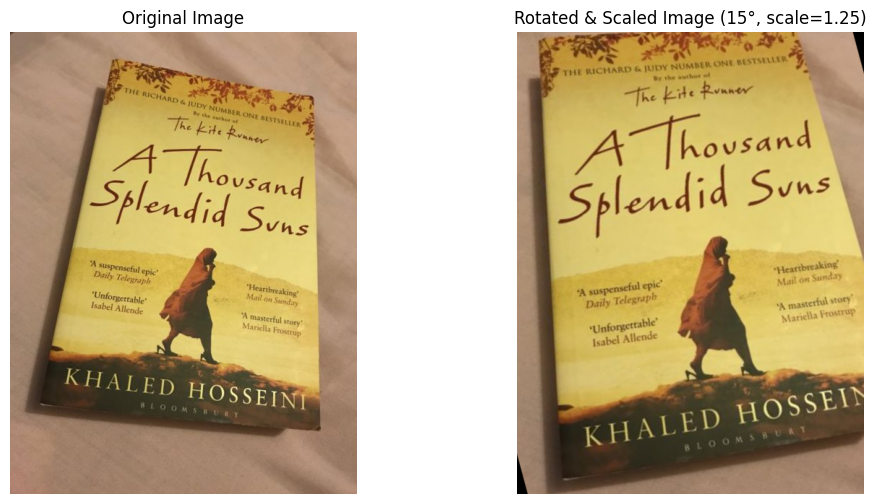

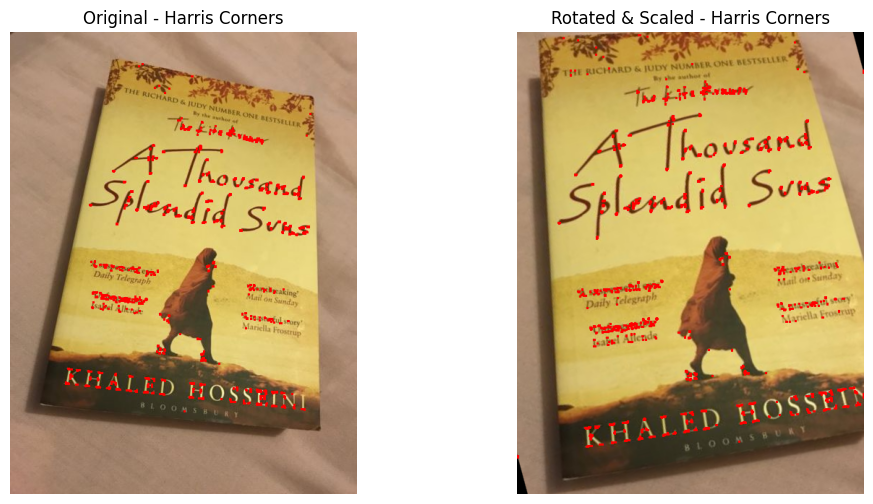

Estimated rotation (degrees): 15.204434737835495
Estimated scale: 1.2472116140082419


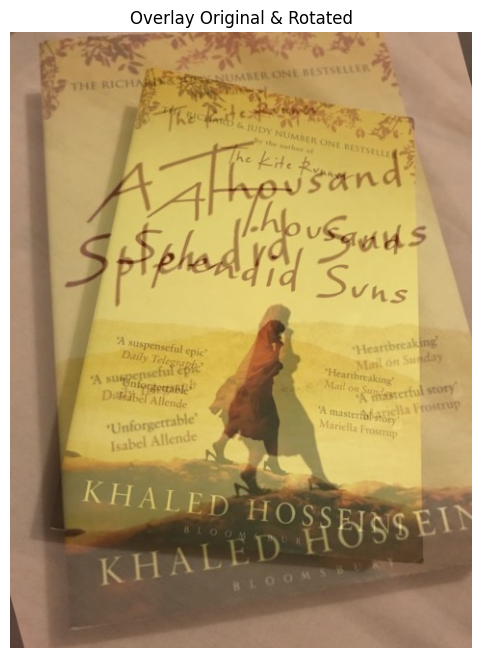

In [16]:
# Load image
img = cv2.imread('data/book1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Rotate image by a random degrees and scale it
angle = 15
scale_factor = 1.25
h, w = img.shape[:2]
center = (w//2, h//2)
M = cv2.getRotationMatrix2D(center, angle, scale_factor)
rotated = cv2.warpAffine(img, M, (w, h))

# Display original and rotated side by side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title(f"Rotated & Scaled Image ({angle}°, scale={scale_factor})")
plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Harris corner detection function
def harris_corners(img, blockSize=2, ksize=3, k=0.04, thresh=0.04):
    gray = np.float32(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    dst = cv2.cornerHarris(gray, blockSize, ksize, k)
    dst = cv2.dilate(dst, None)
    img_c = img.copy()
    img_c[dst > thresh * dst.max()] = [0, 0, 255]
    corners = np.argwhere(dst > thresh * dst.max())
    corners = [tuple(pt[::-1]) for pt in corners]  # (x, y)
    return img_c, corners

# Detect corners on both images
img_c_orig, corners_orig = harris_corners(img)
img_c_rot, corners_rot = harris_corners(rotated)

# Display corners side by side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original - Harris Corners")
plt.imshow(cv2.cvtColor(img_c_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Rotated & Scaled - Harris Corners")
plt.imshow(cv2.cvtColor(img_c_rot, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# ORB descriptors on Harris corners
orb = cv2.ORB_create()
kp_orig = [cv2.KeyPoint(float(c[0]), float(c[1]), 3) for c in corners_orig]
kp_rot = [cv2.KeyPoint(float(c[0]), float(c[1]), 3) for c in corners_rot]
kp_orig, des_orig = orb.compute(gray, kp_orig)
kp_rot, des_rot = orb.compute(cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY), kp_rot)

# Match descriptors
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_orig, des_rot)
matches = sorted(matches, key=lambda x: x.distance)

# Extract matched keypoints
src_pts = np.float32([kp_orig[m.queryIdx].pt for m in matches]).reshape(-1,2)
dst_pts = np.float32([kp_rot[m.trainIdx].pt for m in matches]).reshape(-1,2)

# Estimate affine transformation (includes rotation + scale)
if len(matches) >= 3:
    M_affine, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts)
    # Extract rotation angle
    rotation_rad = np.arctan2(M_affine[0,1], M_affine[0,0])
    rotation_deg_est = np.degrees(rotation_rad)
    # Extract scale
    scale_est = np.sqrt(M_affine[0,0]**2 + M_affine[0,1]**2)
else:
    rotation_deg_est = None
    scale_est = None

# Display estimated rotation and scale
print("Estimated rotation (degrees):", rotation_deg_est)
print("Estimated scale:", scale_est)

# Overlay original and rotated images with some transparency
overlay = cv2.addWeighted(img, 0.5, rotated, 0.5, 0)
plt.figure(figsize=(8,8))
plt.title("Overlay Original & Rotated")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()